<a href="https://colab.research.google.com/github/grayfactory/session_project/blob/main/session1_project_with_Md__description.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
mfile = files.upload()

Saving vgames2.csv to vgames2.csv


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import t, sem
from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans 

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')
# sns.set_style("whitegrid")

In [ ]:
# pandas 출력 길이 설정
pd.set_option('display.max_columns', 50)  # or 1000
pd.set_option('display.max_rows', 50)  # or 1000
pd.set_option('display.max_colwidth', -1)  # or 199

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


In [3]:
df = pd.read_csv('vgames2.csv', index_col=0)
df.head()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
1,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,0.04,0,0,0
2,The Munchables,Wii,2009.0,Action,Namco Bandai Games,0.17,0,0,0.01
3,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0,0,0.02,0
4,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,0.04,0,0,0
5,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,0.12,0.09,0,0.04


# 데이터 전처리 수행
1. 결측치 확인
  - 결측치 처리 방법 결정
    * 전체 매출액에서 결측치를 가진 데이터가 차지하는 비율
    * 매출액을 z-score 표준화 하였을 때, z 값이 1 이상인 데이터 확인 
2. feature engineering
  - 글로벌 매출액 (4개 시장 매출의 합)
  - 표준화 매출액 (z-scored 매출액)
  - 년도 구분
    * 기존 데이터는 1980년 부터 2020년 까지 1년씩 구분됨
    * 90년 이전 까지 하나로 묶고, 이후 3년 단위로 년도를 묶어서 그룹화

--- 

## 결측치 확인 및 처리방법 결정

In [4]:
def fix_year(x):
  if x < 1000:
    if x < 50:
      return x + 2000
    else:
      return x + 1900
  else :
    return x # 년도가 멀쩡
# 년도 수정
df['Year'] = df['Year'].apply(lambda x: fix_year(x))

In [5]:
# 결측치 확인
print('year 결측치 수  ',df['Year'].isna().sum()) # 년도 결측치
print('장르 종류와 결측치 수   ',df['Genre'].value_counts(dropna=False)) # 장르 결측 50개 상대적으로 결측이 적으니까 언노운으로
# df[df['Genre'].isna()]
df_pub_na = df['Publisher'].value_counts(dropna=False)
df_pub_na.head() # unknown 203개 / nan 58개 둘 다 있음, 몇몇 재작사 비율이 매우큼

year 결측치 수   271
장르 종류와 결측치 수    Action          3305
Sports          2341
Misc            1734
Role-Playing    1483
Shooter         1308
Adventure       1280
Racing          1243
Platform         884
Simulation       865
Fighting         847
Strategy         680
Puzzle           578
NaN               50
Name: Genre, dtype: int64


Electronic Arts                 1351
Activision                       975
Namco Bandai Games               932
Ubisoft                          921
Konami Digital Entertainment     832
Name: Publisher, dtype: int64

In [6]:
# 매출엑에 M,K 가 붙은 데이터 중에 소문자 대문자 이상있는지 확인.
p = re.compile('[0-9]+K', re.I) # re.I 인자는 대소문자 무시하는 옵션
strk = [i for i in df['NA_Sales'].values if len(re.findall(p,i))>0]
p = re.compile('[0-9]+M', re.I)
strM = [i for i in df['NA_Sales'].values if len(re.findall(p,i))>0] 

In [7]:
def preprocessing_sales(x):
  # str input // return int
  # 1M = 1000K // 0.001M = 1K
  # K, M 이 붙어 있는 경우 제거 & . 제거 int return
  if len(re.findall('[0-9]+K',x)) == 1:
    return int(x.replace('K','').replace('.','')) * 0.001
  elif len(re.findall('[0-9]+M',x)) == 1:
    return int(x.replace('M','').replace('.',''))
  else:
    return int(x.replace('.',''))
# sales 문자 제거
df['NA_Sales'] = df['NA_Sales'].apply(lambda x: preprocessing_sales(x))
df['EU_Sales'] = df['EU_Sales'].apply(lambda x: preprocessing_sales(x))
df['JP_Sales'] = df['JP_Sales'].apply(lambda x: preprocessing_sales(x))
df['Other_Sales'] = df['Other_Sales'].apply(lambda x: preprocessing_sales(x))

In [8]:
df.head()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
1,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,4.0,0.0,0.0,0.0
2,The Munchables,Wii,2009.0,Action,Namco Bandai Games,17.0,0.0,0.0,1.0
3,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0.0,0.0,2.0,0.0
4,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,4.0,0.0,0.0,0.0
5,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,12.0,9.0,0.0,4.0


In [9]:
# 전체 매출액에서 nan 값들이 차지하는 비율을 구해보자
# 비율에 따라서 해당 결측치를 어떻게 처리할 지 결정
sale_ratio_missing = dict()
vari = ['Year','Genre','Publisher']

# year 274개 missing의 매출액은 전체의 몇 % 인가?
sale_ratio_missing[f'{vari[0]}_na'] = df.loc[df['Year'].isna(),['NA_Sales','EU_Sales','JP_Sales','Other_Sales']].sum()
sale_ratio_missing[f'{vari[0]}_on'] = df.loc[~df['Year'].isna(),['NA_Sales','EU_Sales','JP_Sales','Other_Sales']].sum()
sale_ratio_missing[f'{vari[0]}_ratio'] = sale_ratio_missing[f'{vari[0]}_na'] / sale_ratio_missing[f'{vari[0]}_on']
print('year 274개 missing의 매출액은 전체의 몇 % 인가?\n',sale_ratio_missing['Year_ratio'])
# Genre 50개 missing의 매출액은 전체의 몇 % 인가?
sale_ratio_missing[f'{vari[1]}_na'] = df.loc[df['Genre'].isna(),['NA_Sales','EU_Sales','JP_Sales','Other_Sales']].sum()
sale_ratio_missing[f'{vari[1]}_on'] = df.loc[~df['Genre'].isna(),['NA_Sales','EU_Sales','JP_Sales','Other_Sales']].sum()
sale_ratio_missing[f'{vari[1]}_ratio'] = sale_ratio_missing[f'{vari[1]}_na'] / sale_ratio_missing[f'{vari[1]}_on']
print('Genre 50개 missing의 매출액은 전체의 몇 % 인가?\n',sale_ratio_missing['Genre_ratio'])
# Publisher 50개 missing의 매출액은 전체의 몇 % 인가?
sale_ratio_missing[f'{vari[2]}_na'] = df.loc[ (df['Publisher'].isin(['Unknown']) | df['Publisher'].isna()) , ['NA_Sales','EU_Sales','JP_Sales','Other_Sales']].sum()
sale_ratio_missing[f'{vari[2]}_on'] = df.loc[ (df['Publisher'].isin(['Unknown']) | ~df['Publisher'].isna()) , ['NA_Sales','EU_Sales','JP_Sales','Other_Sales']].sum()
sale_ratio_missing[f'{vari[2]}_ratio'] = sale_ratio_missing[f'{vari[2]}_na'] / sale_ratio_missing[f'{vari[2]}_on']
print('Publisher 50개 missing의 매출액은 전체의 몇 % 인가?\n',sale_ratio_missing['Publisher_ratio'])
# year, Genre, publiser에서 단 1개라도 missing이 있는 데이터의 매출액 비율은?
idx_na = ( df['Year'].isna() | df['Genre'].isna() | (df['Publisher'].isin(['Unknown']) | df['Publisher'].isna()) )
idx_on = ~( df['Year'].isna() | df['Genre'].isna() | (df['Publisher'].isin(['Unknown']) | df['Publisher'].isna()) )
sale_ratio_missing['all_missing'] = df.loc[idx_na,['NA_Sales','EU_Sales','JP_Sales','Other_Sales']].sum()
sale_ratio_missing['all_include'] = df.loc[idx_on,['NA_Sales','EU_Sales','JP_Sales','Other_Sales']].sum()
sale_ratio_missing['all_ratio'] = sale_ratio_missing['all_missing'] / sale_ratio_missing['all_include'] 
print('year, Genre, publiser에서 단 1개라도 missing이 있는 데이터의 매출액 비율은?\n',sale_ratio_missing['all_ratio'])

year 274개 missing의 매출액은 전체의 몇 % 인가?
 NA_Sales       0.013959
EU_Sales       0.010865
JP_Sales       0.005297
Other_Sales    0.011292
dtype: float64
Genre 50개 missing의 매출액은 전체의 몇 % 인가?
 NA_Sales       0.003324
EU_Sales       0.005519
JP_Sales       0.011270
Other_Sales    0.007394
dtype: float64
Publisher 50개 missing의 매출액은 전체의 몇 % 인가?
 NA_Sales       0.005894
EU_Sales       0.004958
JP_Sales       0.005429
Other_Sales    0.004058
dtype: float64
year, Genre, publiser에서 단 1개라도 missing이 있는 데이터의 매출액 비율은?
 NA_Sales       0.020113
EU_Sales       0.018856
JP_Sales       0.019611
Other_Sales    0.020380
dtype: float64


### 결측치 처리 방안
- 매출엑에 차지하는 비율이 2%로 작음
- 글로벌 매출액을 산출하고, z-score 표준화 수행 후, 결정
---
### feature engineering
1. 글로벌 매축액 = 4개 시장 매출액의 합
2. 표준화 매출 값 = 각각의 시장별로 z-scoreed 표준화 수행
---


In [11]:
# 글로벌 매출액 
df['Global_Sales'] = df.NA_Sales + df.EU_Sales + df.JP_Sales + df.Other_Sales
df.head()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
1,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,4.0,0.0,0.0,0.0,4.0
2,The Munchables,Wii,2009.0,Action,Namco Bandai Games,17.0,0.0,0.0,1.0,18.0
3,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0.0,0.0,2.0,0.0,2.0
4,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,4.0,0.0,0.0,0.0,4.0
5,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,12.0,9.0,0.0,4.0,25.0


In [12]:
df.columns[5:]

Index(['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales'], dtype='object')

In [13]:
norm = StandardScaler().fit_transform(df.iloc[:,5:]) # sales 부분만 표준화
print('norm array shape : ',norm.shape)
norm = pd.DataFrame(norm, columns=df.columns[5:], index=df.index ) 
# index를 정확하게 설정해 주는게 중요함,
# subset으로 떼어냈떤 index를 붙여주어야 합칠때 원래 index를 보고 합쳐짐.
# df_subset['']
cols = ['NA_Sales',	'EU_Sales',	'JP_Sales',	'Other_Sales','Global_Sales']
for i in cols:
  df[f'{i}_norm'] = norm[f'{i}']

norm array shape :  (16598, 5)


### 결측치 처리 방법 결정
- 글로벌 매출의 표준화 값 z-scored > 1 인 데이터 확인
- 해당 데이터는 매출액에 영향을 줄 수 있다고 판단,
- 13건으로 수가 많지 않기 때문에 직접 입력

In [ ]:
# idx_na: 1개라도 nan을 포함하는 row
# 표준화 글로벌 매출의 절대값이 1이상 - 매출이 많은 작품 13개 nan 값을 조사해서 채움
nan_list_up = df[ (idx_na & (df['Global_Sales_norm'].abs() > 1) ) ]
nan_list_up

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,NA_Sales_norm,EU_Sales_norm,JP_Sales_norm,Other_Sales_norm,Global_Sales_norm
32,Rock Band,X360,NaN,Misc,Electronic Arts,193.00,34.0,0.0,21.0,248.00,2.161015,0.430562,-0.242680,0.895267,1.373990
1972,Pokemon X/Pokemon Y,3DS,2013.0,NaN,Nintendo,5.17,405.0,434.0,79.0,923.17,-0.241915,8.137713,14.882820,4.037251,6.030785
2131,Call of Duty 3,Wii,NaN,Shooter,Activision,119.00,84.0,0.0,23.0,226.00,1.214325,1.469262,-0.242680,1.003611,1.222251
3348,LEGO Batman: The Videogame,Wii,NaN,Action,Warner Bros. Interactive Entertainment,186.00,102.0,0.0,29.0,317.00,2.071463,1.843194,-0.242680,1.328644,1.849898
3563,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,NaN,157.00,102.0,0.0,41.0,300.00,1.700463,1.843194,-0.242680,1.978710,1.732645
4599,Wii Party,Wii,2010.0,NaN,Nintendo,179.00,353.0,249.0,68.0,849.00,1.981911,7.057465,8.435314,3.441357,5.519219
6950,Madden NFL 2004,PS2,NaN,Sports,Electronic Arts,426.00,26.0,1.0,71.0,524.00,5.141810,0.264370,-0.207829,3.603874,3.277622
8530,LEGO Indiana Jones: The Original Adventures,Wii,NaN,Action,LucasArts,154.00,63.0,0.0,22.0,239.00,1.662084,1.033008,-0.242680,0.949439,1.311915
9489,Final Fantasy XII,PS2,2006.0,NaN,Square Enix,188.00,0.0,233.0,174.0,595.00,2.097049,-0.275754,7.877692,9.183603,3.767325
10966,FIFA Soccer 2004,PS2,NaN,Sports,Electronic Arts,59.00,236.0,4.0,51.0,350.00,0.446738,4.626908,-0.103275,2.520431,2.077506


In [ ]:
# 검색용
df[df.Name.str.contains('Wii')]

In [ ]:
# 13개 데이터 만 직접 입력함
df.loc[df['Name']==nan_list_up.Name.to_numpy()[0],'Year'] = 2007
df.loc[df['Name']==nan_list_up.Name.to_numpy()[1],'Genre'] = 'Role-Playing'
df.loc[df['Name']==nan_list_up.Name.to_numpy()[2],'Year'] = 2006
df.loc[df['Name']==nan_list_up.Name.to_numpy()[3],'Year'] = 2008 
df.loc[df['Name']==nan_list_up.Name.to_numpy()[4],'Year'] = 2005
df.loc[df['Name']==nan_list_up.Name.to_numpy()[5],'Genre'] = 'Action'
df.loc[df['Name']==nan_list_up.Name.to_numpy()[6],'Year'] = 2003
df.loc[df['Name']==nan_list_up.Name.to_numpy()[7],'Year'] = 2008
df.loc[df['Name']==nan_list_up.Name.to_numpy()[8],'Genre'] = 'Role-Playing'
df.loc[df['Name']==nan_list_up.Name.to_numpy()[9],'Year'] = 2003
df.loc[df['Name']==nan_list_up.Name.to_numpy()[10],'Genre'] = 'Adventure'
df.loc[df['Name']==nan_list_up.Name.to_numpy()[11],'Year'] = 2001
df.loc[df['Name']==nan_list_up.Name.to_numpy()[12],'Year'] = 1980

In [14]:
nan_list_up = df[ (idx_na & (df['Global_Sales_norm'].abs() > 1) ) ]
nan_list_up # nan 데이터 채워짐 확인

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,NA_Sales_norm,EU_Sales_norm,JP_Sales_norm,Other_Sales_norm,Global_Sales_norm
32,Rock Band,X360,NaN,Misc,Electronic Arts,193.00,34.0,0.0,21.0,248.00,2.161015,0.430562,-0.242680,0.895267,1.373990
1972,Pokemon X/Pokemon Y,3DS,2013.0,NaN,Nintendo,5.17,405.0,434.0,79.0,923.17,-0.241915,8.137713,14.882820,4.037251,6.030785
2131,Call of Duty 3,Wii,NaN,Shooter,Activision,119.00,84.0,0.0,23.0,226.00,1.214325,1.469262,-0.242680,1.003611,1.222251
3348,LEGO Batman: The Videogame,Wii,NaN,Action,Warner Bros. Interactive Entertainment,186.00,102.0,0.0,29.0,317.00,2.071463,1.843194,-0.242680,1.328644,1.849898
3563,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,NaN,157.00,102.0,0.0,41.0,300.00,1.700463,1.843194,-0.242680,1.978710,1.732645
4599,Wii Party,Wii,2010.0,NaN,Nintendo,179.00,353.0,249.0,68.0,849.00,1.981911,7.057465,8.435314,3.441357,5.519219
6950,Madden NFL 2004,PS2,NaN,Sports,Electronic Arts,426.00,26.0,1.0,71.0,524.00,5.141810,0.264370,-0.207829,3.603874,3.277622
8530,LEGO Indiana Jones: The Original Adventures,Wii,NaN,Action,LucasArts,154.00,63.0,0.0,22.0,239.00,1.662084,1.033008,-0.242680,0.949439,1.311915
9489,Final Fantasy XII,PS2,2006.0,NaN,Square Enix,188.00,0.0,233.0,174.0,595.00,2.097049,-0.275754,7.877692,9.183603,3.767325
10966,FIFA Soccer 2004,PS2,NaN,Sports,Electronic Arts,59.00,236.0,4.0,51.0,350.00,0.446738,4.626908,-0.103275,2.520431,2.077506


In [15]:
df_p = df.copy()

### feature engineering
- 년도를 1년씩 구분하지 않고, 3년 단위로 묶어서 구분
- 1900 이전은 1개로 따로 묶음
- 1900 이후 3년 단위로 category 만들어줌

In [18]:
# bin size 설정
bins = np.arange(1990,2020,3) # arange와 linespace는 다름
bins = np.insert(bins,0,0)
print(bins)
labels = ['-1900','91-93','94-96','97-99','00-02','03-05','06-08','09-11','12-14','15-17']
# df_years['Year'] = pd.cut(df_years['Year'], bins, labels).astype(str)

# pandas cut -> bin을 정확하게 지정해서 입력해주면(IntervalIndex라고하는데) label이 무시되고, IntervalIndex로 반환. str로 그냥 바꿔줌
df_p['Year_bin'] = pd.cut(df_p['Year'], bins).astype(str) 

labels = { '(0.0, 1990.0]' :'-1900', # pd.cut() 에서 (] (앞은 미포함) ]뒤는 포함
            '(1990.0, 1993.0]' : '1991-93',
            '(1993.0, 1996.0]' : '1994-96',
            '(1996.0, 1999.0]' : '1997-99',
            '(1999.0, 2002.0]' : '2000-02',
            '(2002.0, 2005.0]' : '2003-05',
            '(2005.0, 2008.0]' : '2006-08',
            '(2008.0, 2011.0]' : '2009-11',
            '(2011.0, 2014.0]' : '2012-14',
            '(2014.0, 2017.0]' : '2015-17' }
# print(labels)
# bin index로 나온 IntervalIndex을  설정한 label로 매칭해주고, 정의가 안되 있으면 nan을 넣어줌
df_p['Year_label'] = df_p['Year_bin'].apply(lambda x: labels.get(x, np.nan))
print('category 년도 별 데이터 수 확인: ')
df_p['Year_label'].value_counts(dropna=False).sort_index()

[   0 1990 1993 1996 1999 2002 2005 2008 2011 2014 2017]
category 년도 별 데이터 수 확인: 


-1900       221
1991-93     144
1994-96     603
1997-99    1006
2000-02    1660
2003-05    2479
2006-08    3638
2009-11    3829
2012-14    1785
2015-17     961
NaN         272
Name: Year_label, dtype: int64

In [ ]:
df_p.head()


## 기본적인 전처리 완료
---
---
# 데이터 분석 시나리오
1. 시간에 따른 장르별 매출액의 변화
  - 년도별 게임 시장의 매출액 판도 변화
    * 게임 전체 매출액과 발매 게임 수 대비 매출엑의 변화 추이 비교
    * 년도별 12개 장르가 년도별로 전체 매출에서 차지하는 비율 비교 
  - 시간 흐름에 따른 게임 시장 변화를 분석에 반영
    * 오래 전 매출액의 정보는 분석에서 제외
2. 성공한 게임의 특징
  - 성공한 게임의 정의
    * 글로벌 매출액 95% 신뢰구간 산출(단측)
    * 95% 신뢰구간 보다 매출액이 큰 경우를 성공한 게임으로 정의
  - 성공한 게임의 특징
    * 매출을 기반으로 성공한 게임을 추출
    * 매출을 제외한 나머지 요인 (출시 년도(category로 만든것), 플랫폼, 장르)을 one-hot-encoding 수행 -> 40 feature
    * PCA 수행
    * 변량의 80% 이상을 설명하는 PC로 축소
    * k-mean clustering 실시
    * Ellbow method로 cluster 수 결정
  - 성공한 게임의 특징 추출
    * cluster의 출시년도, 플랫폼, 장르 갯수의 상위 3개를 종합 하여 판단
3. 성공확률 계산
  - 베이지안 추정을 근거로 성공확률 계산
    * P(성공 | 특정장르) 개념의 조건부 확률
    * 앞서 분석한 결과로 선택한 장르로 출시할 때 VS 다른 장으로 출시할 때 비교
---
--- 

In [20]:
df_p.head()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,NA_Sales_norm,EU_Sales_norm,JP_Sales_norm,Other_Sales_norm,Global_Sales_norm,Year_bin,Year_label
1,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,4.0,0.0,0.0,0.0,4.0,-0.256883,-0.275754,-0.242680,-0.242348,-0.308932,"(2005.0, 2008.0]",2006-08
2,The Munchables,Wii,2009.0,Action,Namco Bandai Games,17.0,0.0,0.0,1.0,18.0,-0.090573,-0.275754,-0.242680,-0.188176,-0.212370,"(2008.0, 2011.0]",2009-11
3,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0.0,0.0,2.0,0.0,2.0,-0.308056,-0.275754,-0.172977,-0.242348,-0.322726,"(2008.0, 2011.0]",2009-11
4,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,4.0,0.0,0.0,0.0,4.0,-0.256883,-0.275754,-0.242680,-0.242348,-0.308932,"(2008.0, 2011.0]",2009-11
5,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,12.0,9.0,0.0,4.0,25.0,-0.154538,-0.088788,-0.242680,-0.025659,-0.164090,"(2008.0, 2011.0]",2009-11


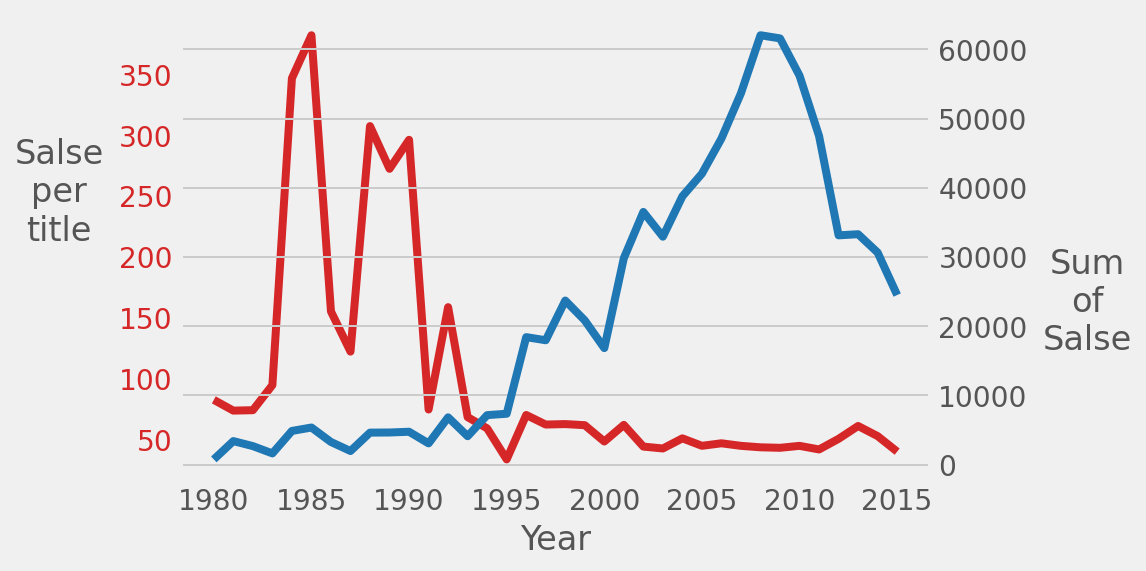

In [21]:
# 시간에 따른 게임 매출액의 증가 기본 그래프
cols = ['Year','Global_Sales']
df_plt = df_p[cols].groupby(['Year']).agg(['sum','size']).reset_index()
df_plt['Sales per titles']= df_plt['Global_Sales']['sum'] / df_plt['Global_Sales']['size']
df_plt = df_plt.loc[df_plt['Year']<2016]

fig, ax = plt.subplots()
ax2 = ax.twinx() # 축 따로 쓰는 방법
sns.lineplot(data=df_plt,x='Year',y=df_plt['Global_Sales']['sum'], ax=ax2, color='tab:blue')
sns.lineplot(data=df_plt,x='Year',y='Sales per titles', ax=ax, color='tab:red')
ax.grid(False)

ax.set_ylabel('Salse\nper\ntitle',rotation=0)
ax.yaxis.labelpad = 30
ax.tick_params(axis='y',labelcolor='tab:red')

ax2.set_ylabel('Sum\nof\nSalse',rotation=0)
ax2.yaxis.labelpad = 30
ax2.tick_params(axis='x',labelcolor='tab:blue')

# fig.savefig('sales_per_titles.jpg',dpi=100)
# fig.savefig('sales.png', bbox_inches='tight', pad_inches=0)


## 1. 시간에 따른 매출액의 판도 변화
- 1997년 이전에 비해 전체 매출액은 가파른 상승 ( 시장 규모는 증가 )
- 발매된 개별 게임의 매출은 50M선으로 평준화 ( 출시작 수가 많음, 경쟁의 심화 )

In [ ]:
# 어떤 장르가 성공하는가?
df_p.head()

In [22]:
print('발매 게임 장르별 갯수 차이 많이 남\n',df_p.groupby(['Genre']).agg('size'))

발매 게임 장르별 갯수 차이 많이 남
 Genre
Action          3305
Adventure       1280
Fighting         847
Misc            1734
Platform         884
Puzzle           578
Racing          1243
Role-Playing    1483
Shooter         1308
Simulation       865
Sports          2341
Strategy         680
dtype: int64


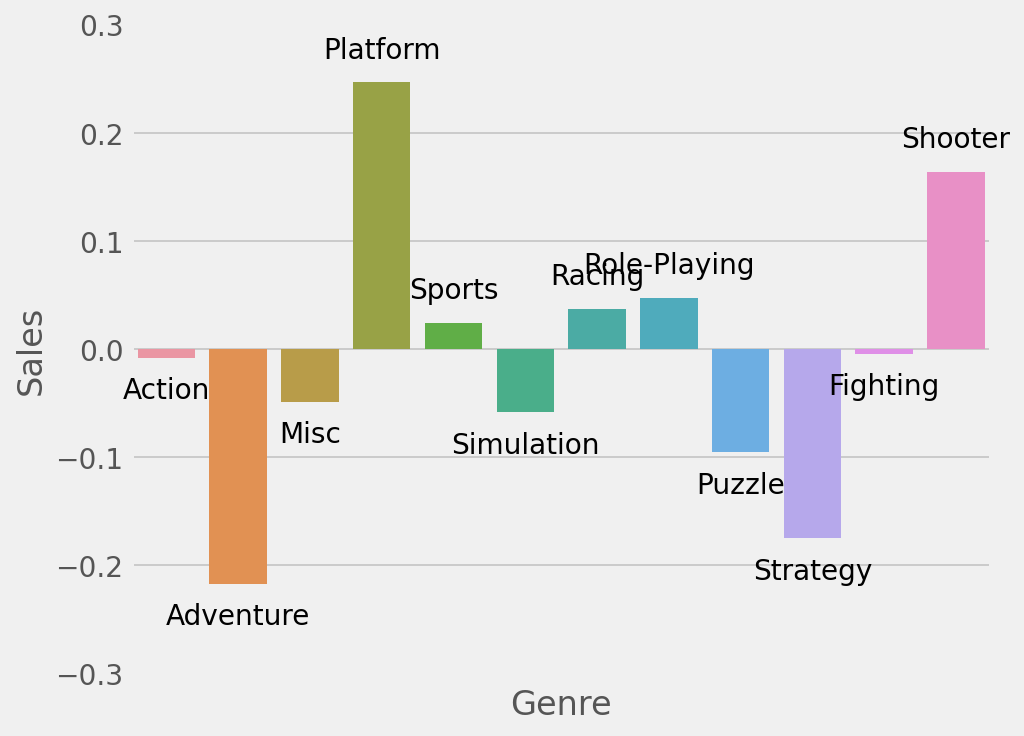

In [24]:
# 장르별 global 매출
# 장르별 표준화 매출액
cols = ['Genre','NA_Sales_norm',	'EU_Sales_norm',	'JP_Sales_norm',	'Other_Sales_norm','Global_Sales_norm']
regions = ['NA_Sales_norm',	'EU_Sales_norm',	'JP_Sales_norm',	'Other_Sales_norm']
df_plt = df_p[cols].melt(id_vars='Genre',var_name='Region',value_name='Sales')
df_plt
genreiter = ['Action', 'Adventure', 'Misc','Platform', 'Sports', 'Simulation', 
             'Racing', 'Role-Playing', 'Puzzle', 'Strategy','Fighting', 'Shooter']
fig, axes = plt.subplots(figsize=(7,5),constrained_layout=True,clear=True)
sns.barplot(x='Genre',y='Sales',data=df_plt.loc[df_plt['Region']=='Global_Sales_norm'], ci=False) 
axes.set_ylim(-0.3,0.3)
for n,p in enumerate(axes.patches):
  heights = p.get_height()
  hpos = 0.03
  if np.abs(heights) > 0.001 or heights > 0.01:
    if heights < 0:
      hpos = hpos * -1
    else :
      hpos = hpos
    
    axes.annotate(f'{genreiter[n]}',(p.get_x() + p.get_width()/2 ,p.get_height()+hpos),
                        ha='center',va='center')
  # axes[r,c].set_xticklabels(axes[r,c].get_xticklabels(),rotation=40)
    axes.set_xticklabels([])
# axes.legend()
# fig.savefig('norm_salse_allyear.png', bbox_inches='tight', pad_inches=0,dpi=100)

### 게임 장르별 표준화 매출액 (모든 년도)
- 1980년도 부터 모든 년도를 포함했을 때, 표준화 글로벌 매출액 (0 점이 평균)
- 1990년 대 중반부터 게임 시장의 판도가 변했을 것으로 앞서서 예측됨
- 시간에 따른 장르별 게임 매출액 비율의 변화를 살펴볼 필요가 있음
  * 시장이 어떻게 변화하였나?

(0, 'NA_Sales_norm')
(1, 'EU_Sales_norm')
(2, 'JP_Sales_norm')
(3, 'Other_Sales_norm')


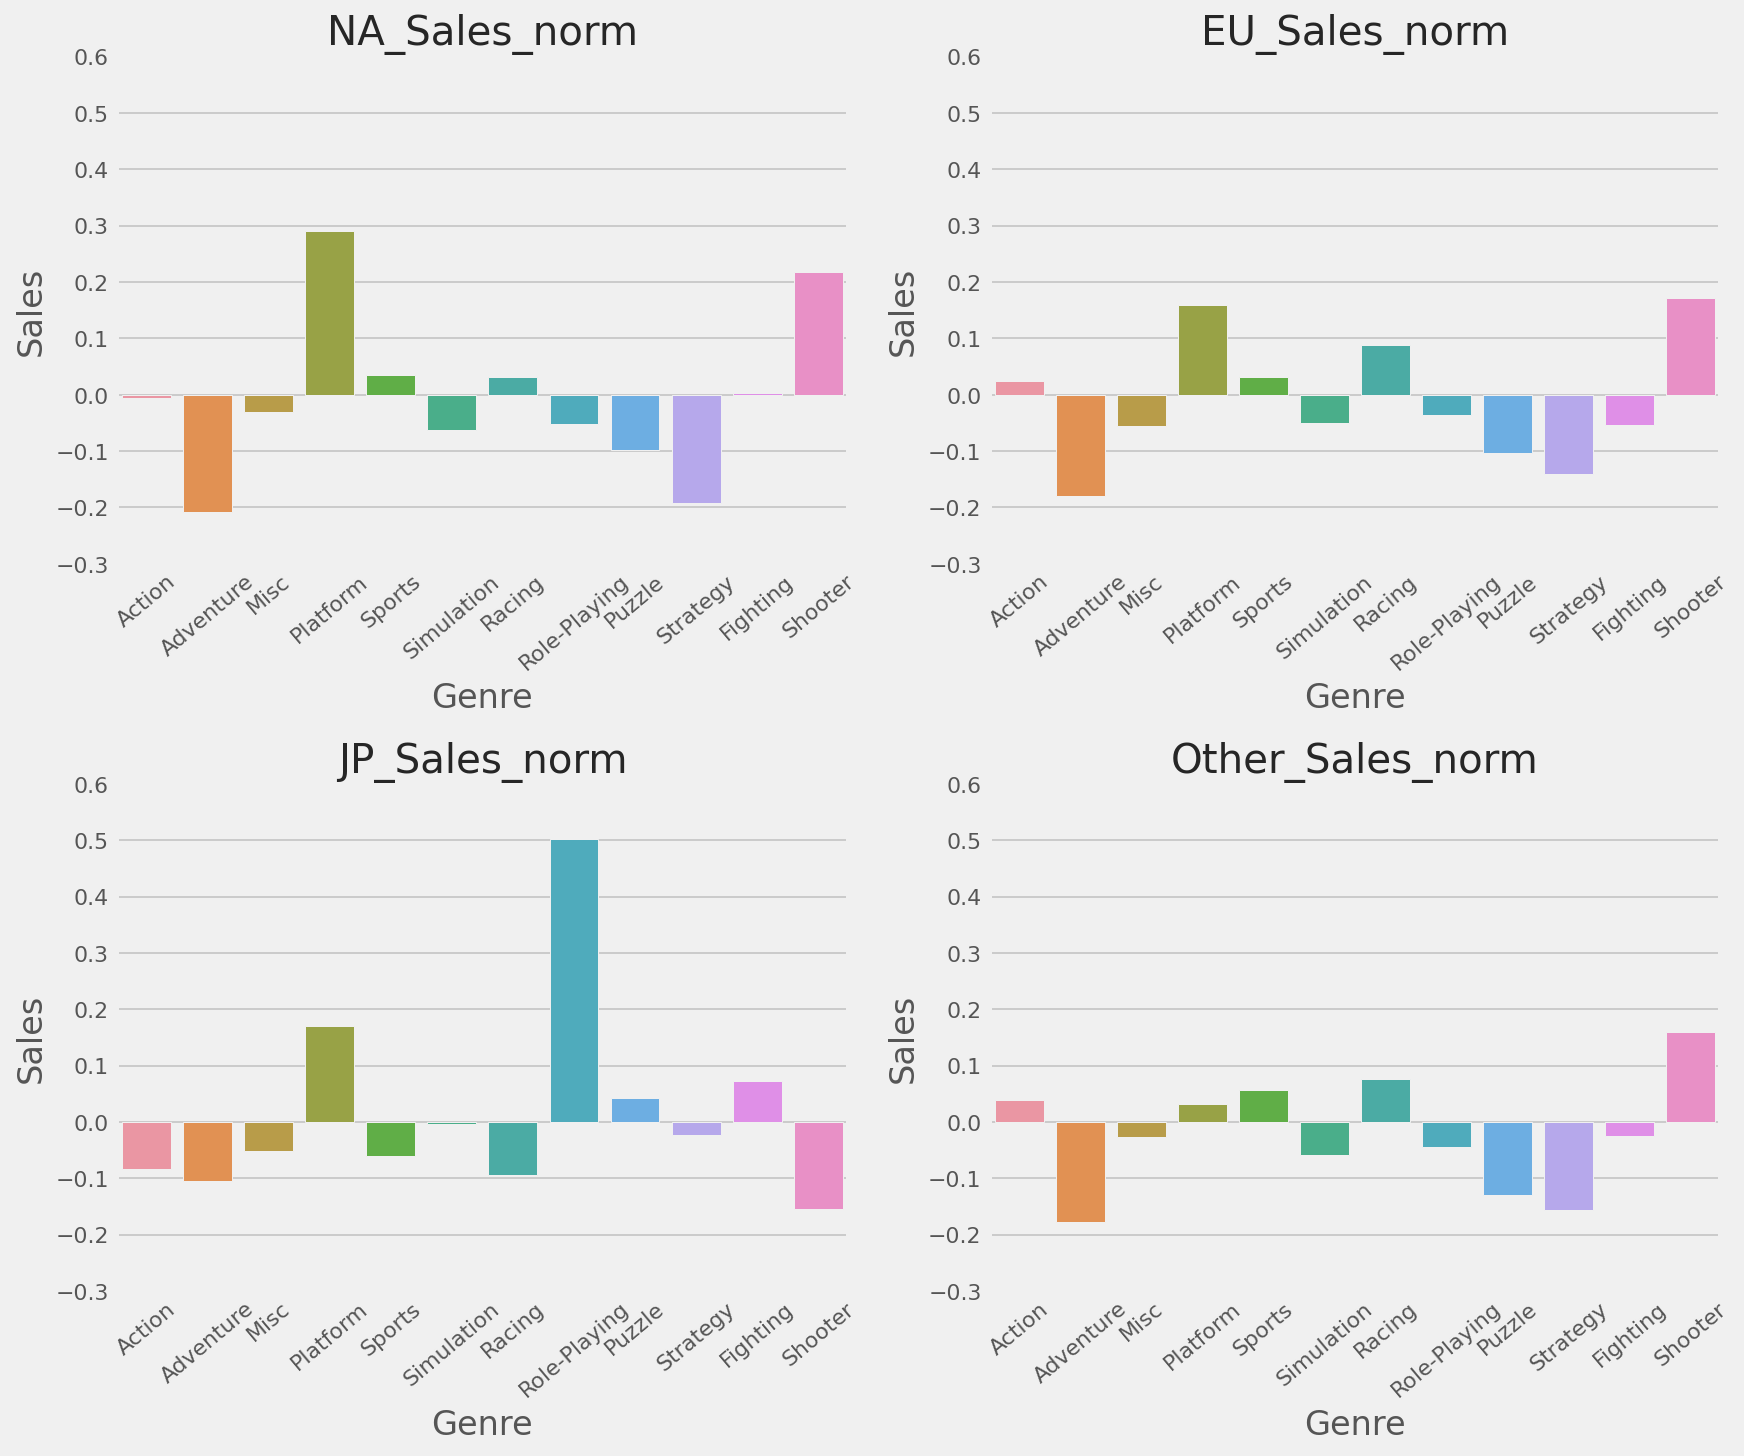

In [ ]:
# 지역별 장르 표준화 매출액
fig, axes = plt.subplots(2,2, figsize=(12,10),constrained_layout=True,clear=True)
for n,i in enumerate(regions):
  print((n,i))
  if n < 2:
    r = 0
    c = n
  else:
    r = 1
    c = n-2
  sns.barplot(x='Genre',y='Sales',data=df_plt.loc[df_plt['Region']==f'{i}'], ax=axes[r,c], ci=False)
  axes[r,c].set_xticklabels(axes[r,c].get_xticklabels(),rotation=40)
  axes[r,c].set_title(f'{i}')
  axes[r,c].set_ylim(-0.3,0.6)
  # 대박 작품이 평균에 영향을 많이 주니까 표준화 시킨다음에 
  # 매출 보면 어떤 장르가 지역에 따라서 평균에 비교해 매출이 많은지 한눈에 볼 수 있지
  fig.savefig('norm_sales_allyear_by_region.png', bbox_inches='tight', pad_inches=0,dpi=100)

> 위의 그래프는 게임 장르 X 시장 표준화 매출액 (모든 년도) 


In [ ]:
# 년도를 bin으로 묶고, 년도에 따라서 장르 매출액의 변화를 구함 
# 단순 매출액 말고 해당년도 전체 매출액에서 각 장르가 차지하는 비율의 변화 추이를 살핌

cols = ['Genre','Platform','Year_label','NA_Sales',	'EU_Sales',	'JP_Sales',	'Other_Sales', 'Global_Sales']
# year & genre 구분해서 groupby
df_years_wide = df_p[cols].groupby(['Year_label','Genre']).agg(['size','mean','std','sum']).stack().reset_index()
# df_year_wide.head()

# year 만 구분해서 groupby 해서 해당년도 전체 매출액 컬럼 만들기
totalvalue = df_p[cols].groupby(['Year_label']).agg(['size','mean','std','sum']).stack().reset_index()
totalvalue = totalvalue.rename({'level_1':'level_2',
                                'NA_Sales':'NA_total',
                                'EU_Sales':'EU_total',
                                'JP_Sales':'JP_total',
                                'Other_Sales':'Other_total',
                                'Global_Sales':'Global_total'}, axis=1)

# merge 해서 총합 value가 있는 column을 붙여줌
df_years_wide = pd.merge(df_years_wide, totalvalue, how='inner',on=['Year_label','level_2'])
# 총합에서 각각 columne의 비율을 산출
cols = ['NA_Sales',	'EU_Sales',	'JP_Sales',	'Other_Sales', 'Global_Sales']
for i in cols:
  df_years_wide[f'{i}_ratio'] = df_years_wide[f'{i}'] / df_years_wide[f'{i.split("_")[0]}_total']
df_years_wide[:13]

,Year_label,Genre,level_2,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,NA_total,EU_total,JP_total,Other_total,Global_total,NA_Sales_ratio,EU_Sales_ratio,JP_Sales_ratio,Other_Sales_ratio,Global_Sales_ratio
0,-1900,Action,size,69.000000,69.000000,69.000000,69.000000,69.000000,225.000000,225.000000,225.000000,225.000000,225.000000,0.306667,0.306667,0.306667,0.306667,0.306667
1,-1900,Adventure,size,2.000000,2.000000,2.000000,2.000000,2.000000,225.000000,225.000000,225.000000,225.000000,225.000000,0.008889,0.008889,0.008889,0.008889,0.008889
2,-1900,Fighting,size,4.000000,4.000000,4.000000,4.000000,4.000000,225.000000,225.000000,225.000000,225.000000,225.000000,0.017778,0.017778,0.017778,0.017778,0.017778
3,-1900,Misc,size,8.000000,8.000000,8.000000,8.000000,8.000000,225.000000,225.000000,225.000000,225.000000,225.000000,0.035556,0.035556,0.035556,0.035556,0.035556
4,-1900,Platform,size,36.000000,36.000000,36.000000,36.000000,36.000000,225.000000,225.000000,225.000000,225.000000,225.000000,0.160000,0.160000,0.160000,0.160000,0.160000
5,-1900,Puzzle,size,21.000000,21.000000,21.000000,21.000000,21.000000,225.000000,225.000000,225.000000,225.000000,225.000000,0.093333,0.093333,0.093333,0.093333,0.093333
6,-1900,Racing,size,10.000000,10.000000,10.000000,10.000000,10.000000,225.000000,225.000000,225.000000,225.000000,225.000000,0.044444,0.044444,0.044444,0.044444,0.044444
7,-1900,Role-Playing,size,11.000000,11.000000,11.000000,11.000000,11.000000,225.000000,225.000000,225.000000,225.000000,225.000000,0.048889,0.048889,0.048889,0.048889,0.048889
8,-1900,Shooter,size,34.000000,34.000000,34.000000,34.000000,34.000000,225.000000,225.000000,225.000000,225.000000,225.000000,0.151111,0.151111,0.151111,0.151111,0.151111
9,-1900,Simulation,size,4.000000,4.000000,4.000000,4.000000,4.000000,225.000000,225.000000,225.000000,225.000000,225.000000,0.017778,0.017778,0.017778,0.017778,0.017778


In [ ]:
# global sales 의 년도별 비율 보기 위해서 선택.
df_plt = df_years_wide.loc[df_years_wide['level_2']=='sum',['Year_label','Genre','Global_Sales_ratio']]

# category 지정
category_names = list(df_plt['Genre'].unique())
# dict 형태로 빼내기 위해서 pivot으로 돌려줌
discret_table = df_plt.pivot(index='Year_label',columns='Genre',values='Global_Sales_ratio').fillna(0)
discret_table.reset_index(inplace=True)

'''
아래 그래프 그리기 위해서 

category_names = ['Strongly disagree', 'Disagree',
                  'Neither agree nor disagree', 'Agree', 'Strongly agree']
results = {
    'Question 1': [10, 15, 17, 32, 26],
    'Question 2': [26, 22, 29, 10, 13],
    'Question 3': [35, 37, 7, 2, 19],
    'Question 4': [32, 11, 9, 15, 33],
    'Question 5': [21, 29, 5, 5, 40],
    'Question 6': [8, 19, 5, 30, 38]
}
이런 형태로 만들기 위한 준비.
results key에 년도 bin이 들어가고
value에 category순서에 맞춰서 row 한줄의 값이 들어감
''' 
results = {}
for j,y in enumerate(list(discret_table['Year_label'].values)):
  tmp = []
  for n,c in enumerate(category_names):
    v = discret_table.loc[discret_table['Year_label'] == y,c].values[0]
    tmp.append(v)
  results[f'{y}'] = tmp
# question key 자리에 bin, value에 category 순서에 맞춰서 값 입력
# results


Action
Adventure
Fighting
Misc
Platform
Puzzle
Racing
Role-Playing
Shooter
Simulation
Sports
Strategy


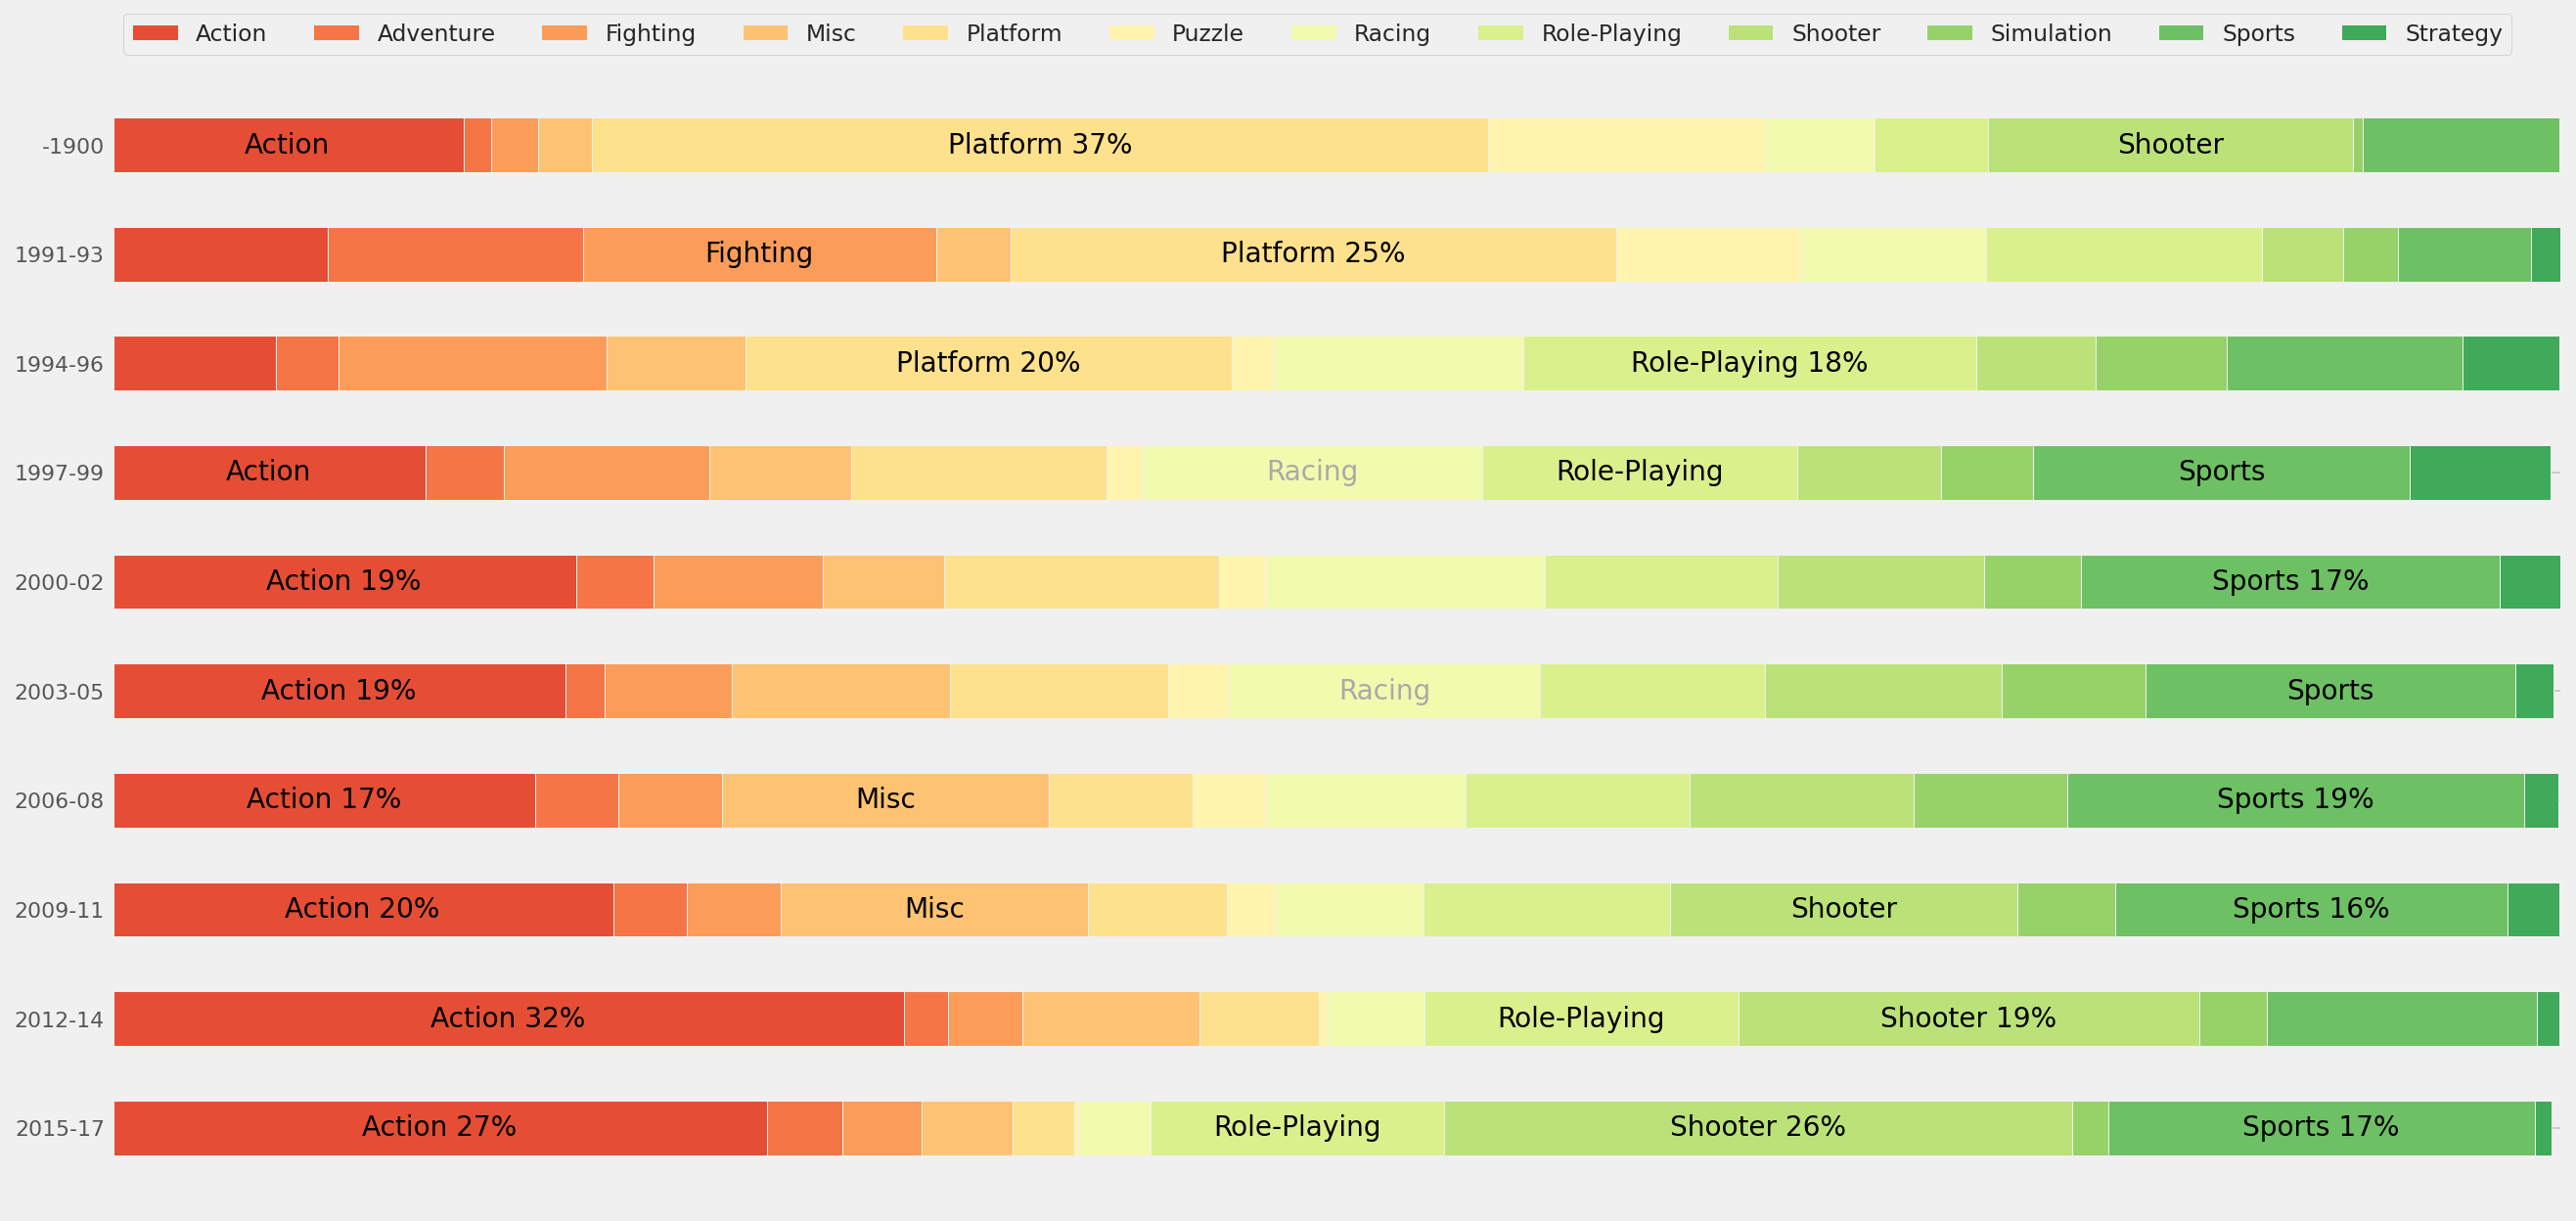

In [ ]:
def survey(results, category_names):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    # sns.set()
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.get_cmap('RdYlGn')(
        np.linspace(0.15, 0.85, data.shape[1]))
    # print(category_colors)

    fig, ax = plt.subplots(figsize=(20, 10))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        ax.barh(labels, widths, left=starts, height=0.5,
                label=colname, color=color)
        xcenters = starts + widths / 2
        print(colname)
        r, g, b, _ = color
        # text_color = 'white' if r * g * b < 0.5 else 'darkgrey' 
        text_color = 'black' if r * g * b < 0.5 else 'darkgrey' # 글자 색 통일
        for y, (x, c) in enumerate(zip(xcenters, widths)):
          # print(z)
          if round(c,2) > 0.15:
            # 15% 이상 점유율은 % 표시
            ax.text(x, y, colname+' '+str(int(round(c,2)*100))+'%', ha='center', va='center', 
                    color=text_color)
          elif round(c,2) > 0.11: 
            # ax.text(x, y, str(int(round(c,2)*100)), ha='center', va='center', # %로 표시되도록 변경
            #         color=text_color)
            # 11% 이상 점유율은 장르 명칭만 표시
            ax.text(x, y, colname, ha='center', va='center', # %로 표시되도록 변경
                    color=text_color)

    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')
    fig.savefig('genre_per_year2.png', bbox_inches='tight', pad_inches=0,dpi=100)
    return fig, ax
survey(results, category_names)
plt.show()
# fig.savefig('genre_per_year2.png', bbox_inches='tight', pad_inches=0,dpi=100)

> 위 그래프, 년도별 전체 매출액에서 12개 장르가 차지하는 비율
### 시간의 흐름에 따른 시장 변화
- 90년대 초반과 2000년대의 장르별 매출액의 비율의 차이가 큼
- 1997년 이후, 시장 구조가 현재와 유사함
- 1997년 이전 데이터는 이후 분석에서 제외
  * 우리의 목적은 현재 성공한 게임을 분석해서 2/4분기 출시 게임을 결정하기 위함

(0, 'NA_Sales_norm')
(1, 'EU_Sales_norm')
(2, 'JP_Sales_norm')
(3, 'Other_Sales_norm')


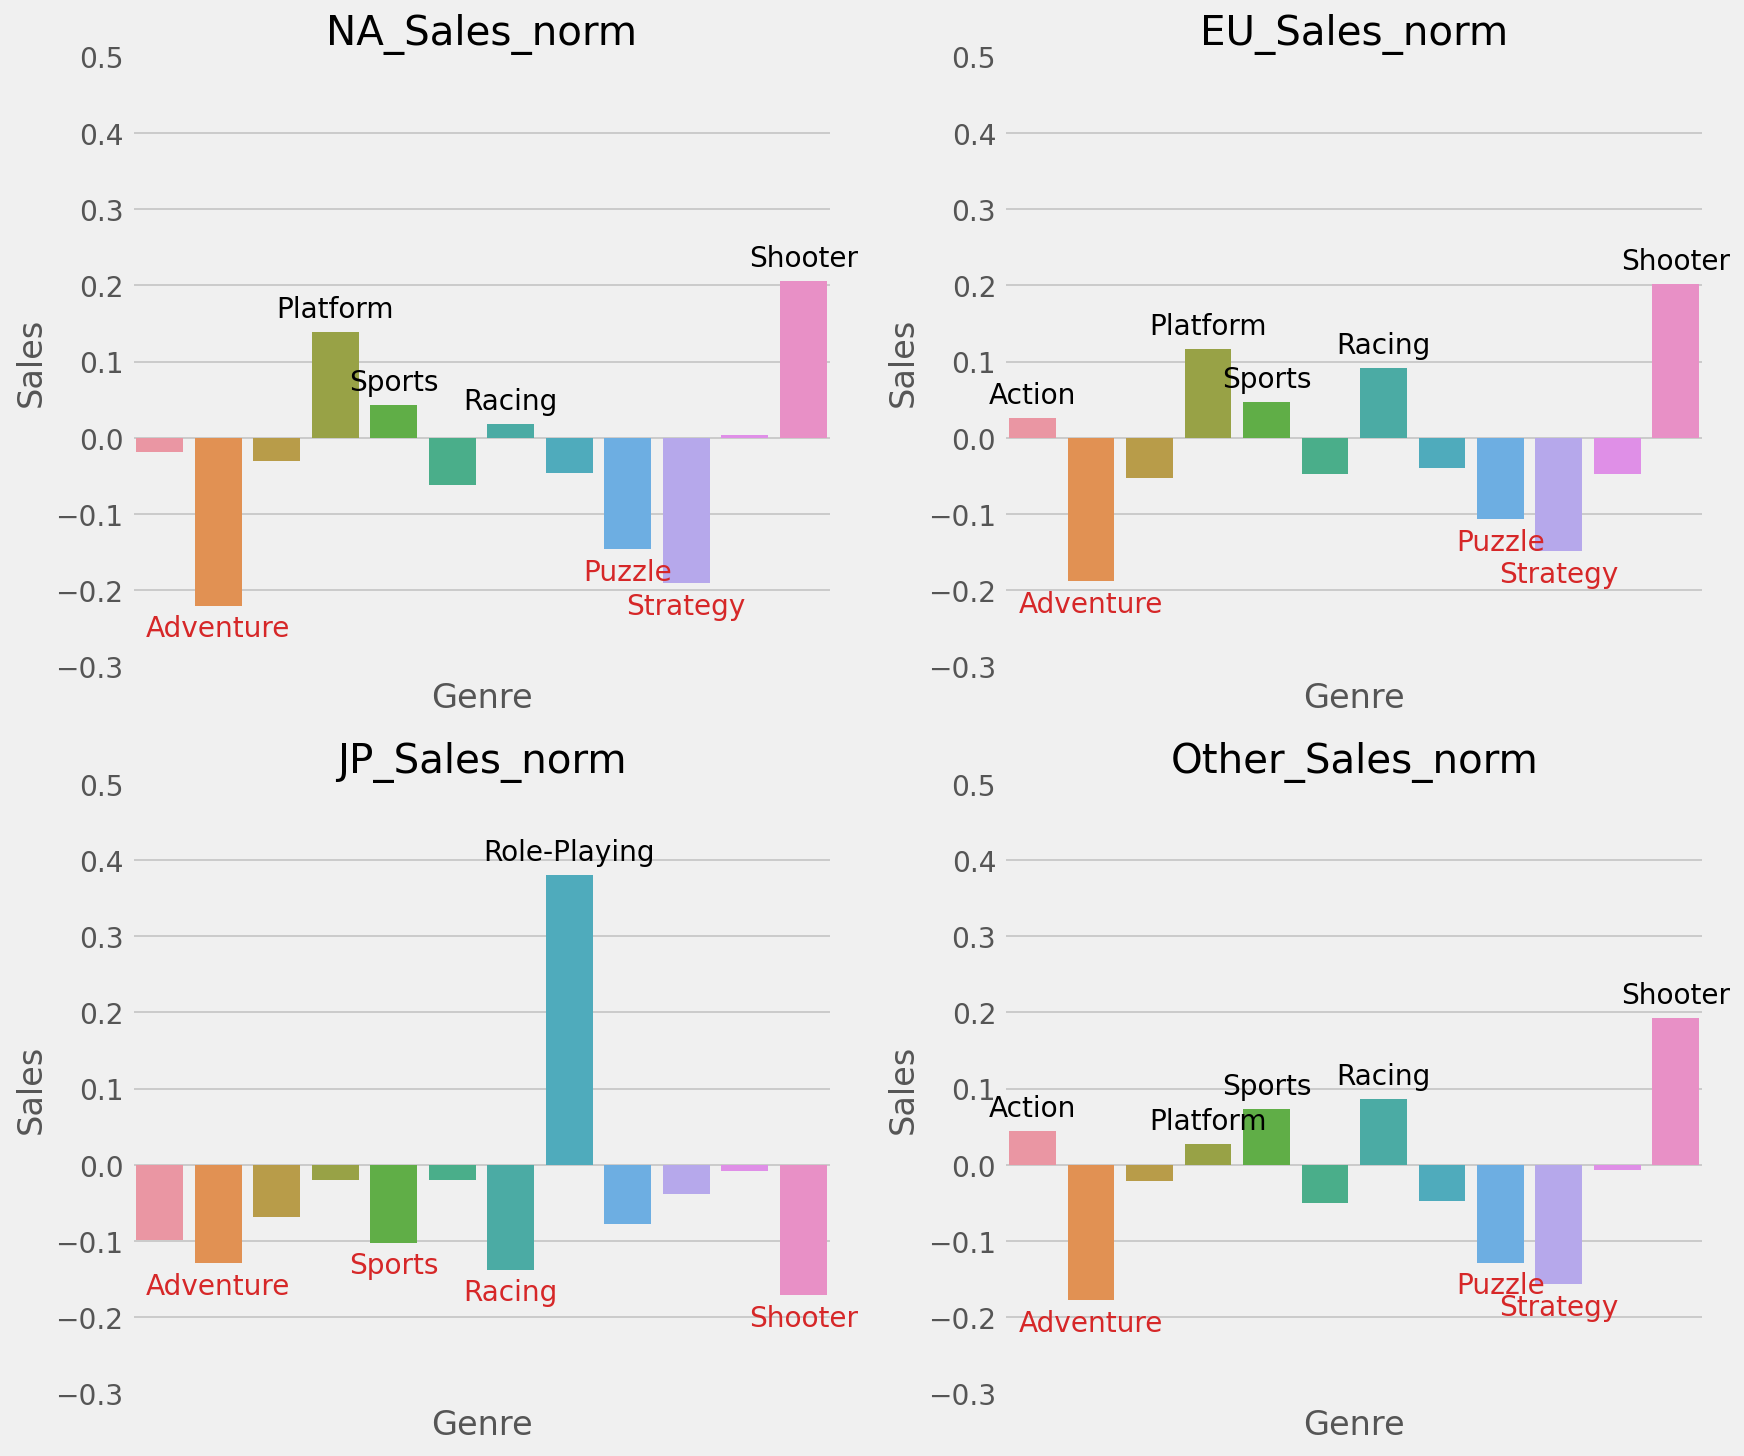

In [25]:
# df_py = df_p.loc[df_p['Year']>1996]

# 장르별 global 매출
# 장르별 표준화 매출액
cols = ['Genre','NA_Sales_norm',	'EU_Sales_norm',	'JP_Sales_norm',	'Other_Sales_norm','Global_Sales_norm']
regions = ['NA_Sales_norm',	'EU_Sales_norm',	'JP_Sales_norm',	'Other_Sales_norm']
# year filter 1996 적용
df_plt = df_p.loc[df_p['Year']>1996, cols].melt(id_vars='Genre',var_name='Region',value_name='Sales')
df_plt
# 지역별 장르 표준화 매출액
fig, axes = plt.subplots(2,2, figsize=(12,10),constrained_layout=True,clear=True)
genreiter = ['Action', 'Adventure', 'Misc','Platform', 'Sports', 'Simulation', 
             'Racing', 'Role-Playing', 'Puzzle', 'Strategy','Fighting', 'Shooter']
for n,i in enumerate(regions):
  print((n,i))
  if n < 2:
    r = 0
    c = n
  else:
    r = 1
    c = n-2
  sns.barplot(x='Genre',y='Sales',data=df_plt.loc[df_plt['Region']==f'{i}'], ax=axes[r,c], ci=False)
  axes[r,c].set_title(f'{i}')
  axes[r,c].set_ylim(-0.3,0.5)

  for n,p in enumerate(axes[r,c].patches):
    heights = p.get_height()
    hpos = 0.03
    if np.abs(heights) > 0.1 or heights > 0.01:
      if heights < 0:
        hpos = hpos * -1
        color = 'tab:red'
      else :
        hpos = hpos
        color = 'black'
      axes[r,c].annotate(f'{genreiter[n]}',(p.get_x() + p.get_width()/2 ,p.get_height()+hpos), 
                                            ha='center',va='center',color=color )
    # axes[r,c].set_xticklabels(axes[r,c].get_xticklabels(),rotation=40)
      axes[r,c].set_xticklabels([])

# lines, labels = fig.axes[-1].get_legend_handles_labels()
# # axes[1,1].legend()
# print(lines,label)
fig.savefig('norm_sales_year_filter.png', bbox_inches='tight', pad_inches=0,dpi=100)

> 위 그래프, 1997년 이후 시장 X 장르별 표준화 매출
- 모든 시점을 포함하는 것과 차이가 큼

In [ ]:
# 어떤 플랫폼이 가장 점유율이 높은가
df_p.shape

(16598, 17)

In [ ]:
genre_filter = ['Action','Platform','Sports','Racing','Role-Playing','Shooter'] # 위에서 유망하다고 생각되는 장르만 뽑았음
df_plat = df_p[ (df_p.Year > 1996) & ( df_p.Genre.isin(genre_filter) ) ] # 모든 장르를 대상으로 집계 하지 않음

cols = ['Platform','Genre','Global_Sales_norm']
df_plat = df_plat[cols].groupby(['Genre','Platform']).size().reset_index()
df_plat.columns=['Genre','Platform','size']
# df_plat
df_plat.groupby(['Genre'])['size'].agg(['mean','std'])

# 장르별 플렛폼 평균의 최소 30, 편차가 매우 크기 때문에 최소 20개 이상의 게임이 있는 플렛폼으로 결정
df_plat = df_plat[df_plat['size'] > 50] # 50개 이하의 게임이 있는 플렛폼은 제외
df_plat

In [ ]:
df_plat[df_plat['Genre']=='Action'].sort_values(by='size',ascending=False)

0 Action
1 Platform
2 Sports
3 Racing
4 Role-Playing
5 Shooter


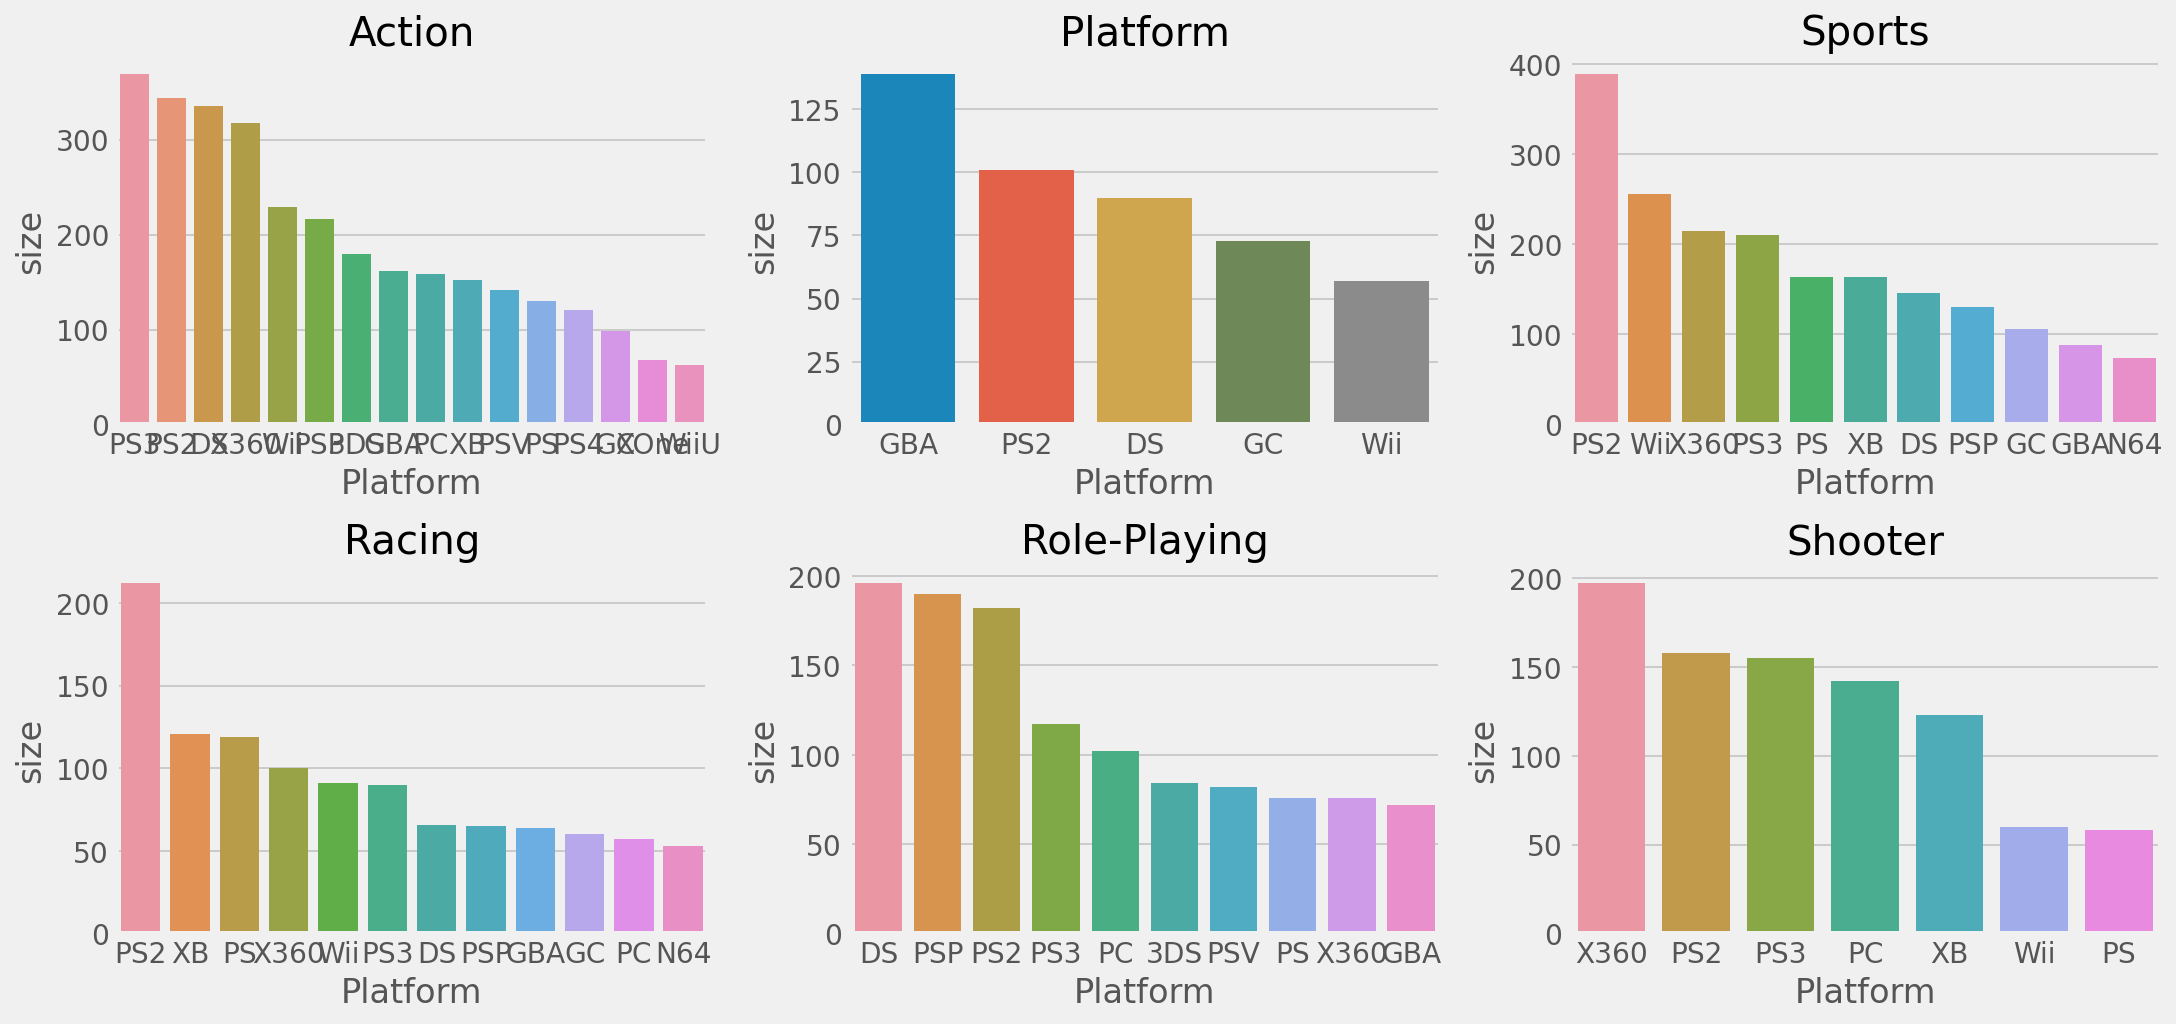

In [27]:
# 유망 장르별로 본 플렛폼의 갯수
# 여기 색 분배, 값 넣어주는거 해결해야 함
fig, axes = plt.subplots(2,3, figsize=(15,7),constrained_layout=True,clear=True)

for n,i in enumerate(genre_filter):
  sorted_data = df_plat[df_plat['Genre']==i].sort_values(by='size',ascending=False)
  
  print(n,i)
  if n < 3:
    r, c = 0, n
  else :
    r, c = 1, n-3
  g = sns.barplot(x='Platform',y='size',data=sorted_data, ci=False, ax = axes[r,c])
  axes[r,c].set_title(i)

> 위 그래프, 'Action', 'Platform', 'Sports', 'Racing', 'Role-Playing', 'Shooter' 장르만 선택, 1997년 이후 해당 플랫폼에서 50게 이상의 게임이 발매된 플랫폼만 나열  
* 유망한 플랫폼은 어떤 것인가? 

---
## 2. 성공한 게임의 특징
### 성공한 게임의 정의
* 글로벌 매출액의 95% 신뢰구간보다 큰 경우
* 성공한 게임을 정의 


In [28]:
df_p.head()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,NA_Sales_norm,EU_Sales_norm,JP_Sales_norm,Other_Sales_norm,Global_Sales_norm,Year_bin,Year_label
1,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,4.0,0.0,0.0,0.0,4.0,-0.256883,-0.275754,-0.242680,-0.242348,-0.308932,"(2005.0, 2008.0]",2006-08
2,The Munchables,Wii,2009.0,Action,Namco Bandai Games,17.0,0.0,0.0,1.0,18.0,-0.090573,-0.275754,-0.242680,-0.188176,-0.212370,"(2008.0, 2011.0]",2009-11
3,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0.0,0.0,2.0,0.0,2.0,-0.308056,-0.275754,-0.172977,-0.242348,-0.322726,"(2008.0, 2011.0]",2009-11
4,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,4.0,0.0,0.0,0.0,4.0,-0.256883,-0.275754,-0.242680,-0.242348,-0.308932,"(2008.0, 2011.0]",2009-11
5,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,12.0,9.0,0.0,4.0,25.0,-0.154538,-0.088788,-0.242680,-0.025659,-0.164090,"(2008.0, 2011.0]",2009-11


In [29]:
def one_tailed_CI(data):
  n = data.shape[0]
  dof = n - 1
  mean = data.mean()
  sample_std = np.std(data, ddof=1)
  std_err = sample_std / n ** 0.5

  upperbound = mean + std_err * t.ppf(0.95, df=dof)
  return upperbound


In [30]:
cols = ['NA_Sales',	'EU_Sales',	'JP_Sales',	'Other_Sales', 'Global_Sales']
upper_ci = dict()
for i in cols:
  upper_ci[f'{i}'] = one_tailed_CI(df_p[f'{i}'])
upper_ci

{'EU_Sales': 13.888614259991721,
 'Global_Sales': 50.64197600499787,
 'JP_Sales': 7.329653219192891,
 'NA_Sales': 25.077876046669363,
 'Other_Sales': 4.709363732042018}

In [31]:
# 글로벌 매출과 년도 조건으로 매출이 높은 게임 선택
df_big = df_p[ (df_p['Global_Sales'] >= upper_ci['Global_Sales']) & (df_p['Year'] > 1996) ]
# cols = ['Name','NA_Sales_norm',	'EU_Sales_norm'	,'JP_Sales_norm',	'Other_Sales_norm',	'Global_Sales_norm',	'Year_label', 'Platform','Genre']

'''
여기서 선택을 해야 하는데, PCA할 때 매출을 넣을지,?
아니면 논리상, 지금 매출이 일정 이상인 게임을 뽑았고. 
그들의 가진 feature들의 특징일 알고 싶으니까
어차피 변량의 대부분을 설명하는 매출을 빼고
나머지 조건들에서 어떤 특징이 있는지를 알아보는 과정?

** 중요 나중에 merge하려면 platform 그대로 가지고 있어야함
'''
cols = ['Name',	'Year_label', 'Platform','Genre'] # 매출을 제거한 후
df_big = df_big[cols]

# categorical feature들 더미변수로
y = pd.get_dummies(df_big['Year_label'])
p = pd.get_dummies(df_big['Platform'])
g = pd.get_dummies(df_big['Genre'])

df_big = pd.concat( [ pd.concat( [pd.concat( [ df_big.iloc[:,:1],y], axis=1) ,
                                                p],axis=1 ), 
                                                g ],axis=1 )
print(df_big.shape)


(3217, 41)


In [ ]:
df_big.head()

,Name,1997-99,2000-02,2003-05,2006-08,2009-11,2012-14,2015-17,3DS,DC,DS,GB,GBA,GC,N64,PC,PS,PS2,PS3,PS4,PSP,PSV,SAT,WS,Wii,WiiU,X360,XB,XOne,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy
21,Ty the Tasmanian Tiger,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
25,Injustice: Gods Among Us,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
32,Rock Band,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
35,Mega Man Anniversary Collection,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
43,Phoenix Wright: Ace Attorney - Trials and Tribulations,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


### 성공한 게임 추출
* 1997년 이후 발매 & 매출액의 95%신뢰구간보다 큰 게임
* 발매년도, 플랫폼, 장르 catetory를 one-hot-encoding 수행
* 40차원 feature

(3217, 40)
1 components는 데이터 분산의 0.103% 를 설명
2 components는 데이터 분산의 0.192% 를 설명
3 components는 데이터 분산의 0.271% 를 설명
4 components는 데이터 분산의 0.342% 를 설명
5 components는 데이터 분산의 0.402% 를 설명
6 components는 데이터 분산의 0.461% 를 설명
7 components는 데이터 분산의 0.512% 를 설명
8 components는 데이터 분산의 0.562% 를 설명
9 components는 데이터 분산의 0.605% 를 설명
10 components는 데이터 분산의 0.645% 를 설명
11 components는 데이터 분산의 0.68% 를 설명
12 components는 데이터 분산의 0.713% 를 설명
13 components는 데이터 분산의 0.743% 를 설명
14 components는 데이터 분산의 0.772% 를 설명
15 components는 데이터 분산의 0.799% 를 설명
16 components는 데이터 분산의 0.822% 를 설명
17 components는 데이터 분산의 0.844% 를 설명
18 components는 데이터 분산의 0.862% 를 설명
19 components는 데이터 분산의 0.878% 를 설명
20 components는 데이터 분산의 0.893% 를 설명
21 components는 데이터 분산의 0.907% 를 설명


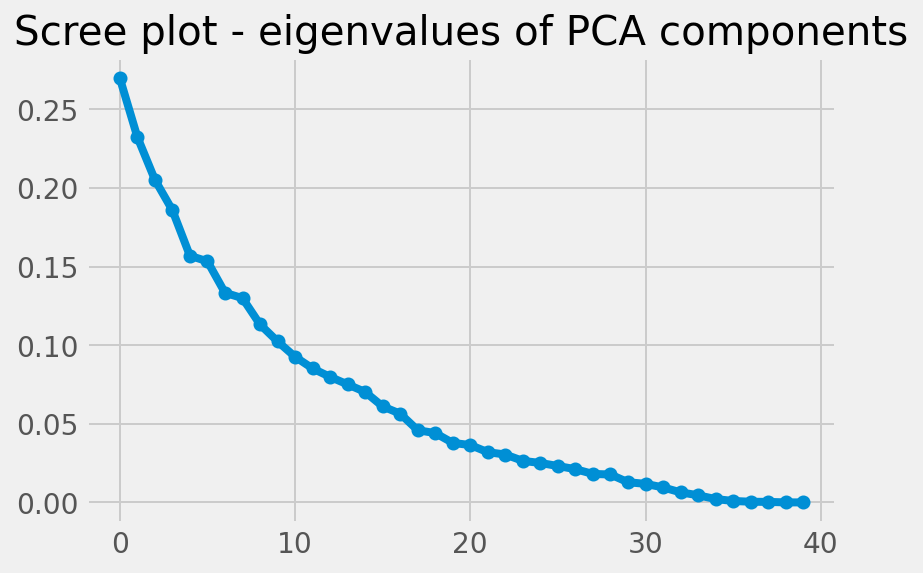

In [32]:
# PCA 수행
n_pc = df_big.shape[1]
pca = PCA(n_components=n_pc-1)
pca_components = pca.fit_transform(df_big.iloc[:,1:])
print(pca_components.shape)

fig, axes = plt.subplots()
axes.plot(pca.explained_variance_,'o-')
axes.set_title('Scree plot - eigenvalues of PCA components')
# plt.plot(pca.explained_variance_,'o-')
# plt.title('')
r = 0
for n, i in enumerate(pca.explained_variance_ratio_):
  r += i
  if np.round(r,2) <= 0.91:
    print(f'{n+1} components는 데이터 분산의 {round(r,3)}% 를 설명')

# 나중에 혹시 그래프 그릴꺼면 참고
  # np.cumsum(pca.explained_variance_)
  # fig, axes = plt.subplots()
  # axes.plot(np.cumsum(pca.explained_variance_),'o-')
  # axes.set_title('Scree plot - eigenvalues of PCA components')
  # ax2 = axes.twinx() # 축 따로 쓰는 방법
  # ax2.plot(pca.explained_variance_ratio_,'o-',color='r')


### PCA 수행
* 80%의 정보를 유지하는 16개 차원으로 축소

In [33]:
df_big.columns.isin(['pc1']).sum()

0

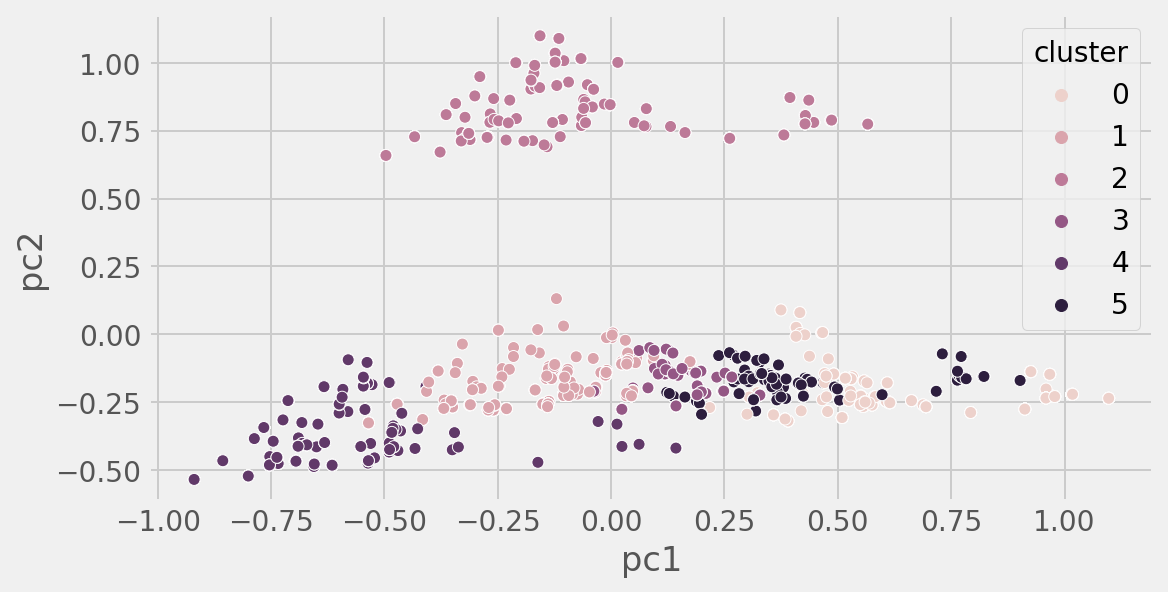

In [34]:
# 40차원으로 시작, 80%는 16개, 90%는 21개 필요
# 16개로 축소시키고 클러스터링 해봄

kmeans = KMeans(n_clusters=6)
kmeans.fit(pca_components[:,:16])
kmeans.labels_.shape

# 여러번 돌릴때마다 pc가 추가로 붙으니까 방지
if df_big.columns.isin(['pc1']).sum() == 0:
  pca_value = pd.DataFrame(pca_components[:,:2], columns=['pc1','pc2'], index=df_big.index.values)
  df_big = pd.concat([df_big, pca_value], axis=1)

cluster_label = pd.Series(kmeans.labels_, index=df_big.index.values)
df_big['cluster'] = cluster_label

fig, axes = plt.subplots(figsize=(8,4),constrained_layout=True)
sns.scatterplot(data=df_big, x='pc1',y='pc2',hue='cluster')
# 어차피 pc16차원이라서 2개 축으로는 못그림

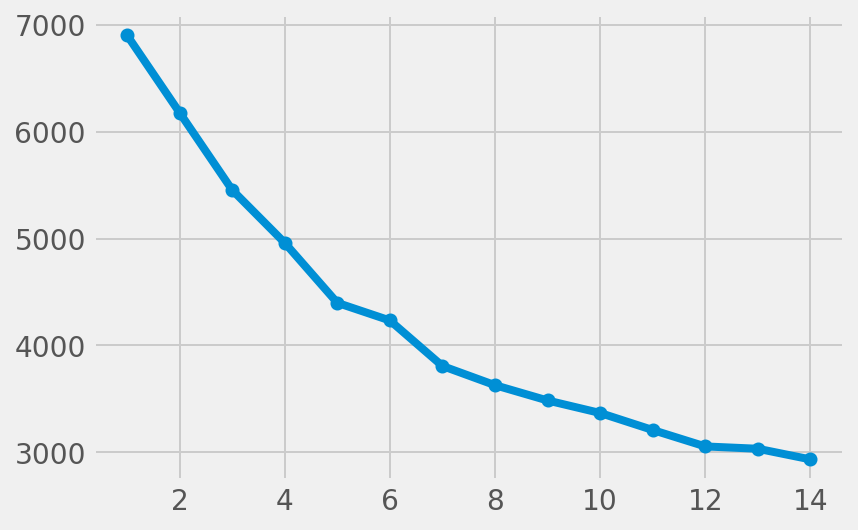

In [35]:
# 클러스터 수가 몇개일때 점들간 거리가 감소하나?
# K값 결정하기 위한 방법

sum_of_squared_distances = []
K = range(1,15)
for k in K:
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(pca_components[:,:16])
  sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,sum_of_squared_distances, 'o-')

### K-mean clustering 수행
* 성공한 게임을 대상으로, 16개 PC를 가지고 clustering 수행
* Ellbow method로 6개 cluster 결정


### 6 개 클러스터 들의 특징
* 각각 클러스터로 분리된 성공한 게임들의 발매 년도, 장르, 플랫폼, 퍼블리셔 갯수의 상위 3개를 추출

In [37]:
df_cluster = df_p[ (df_p['Global_Sales'] >= upper_ci['Global_Sales']) & (df_p['Year'] > 1996) ]
# df_cluster['cluster'] = df_big['cluster']

In [ ]:
df_cluster

In [38]:
# index가 유지되고 있기 때문에 concat해도 괜찮음
df_cluster = pd.concat([df_cluster, df_big[['Name','cluster']]], axis=1)

In [39]:
v = df_cluster.loc[df_cluster.cluster==0,'Genre'].value_counts()
v[:3]

Action     101
Sports      90
Shooter     58
Name: Genre, dtype: int64

In [40]:
for c in range(6):
  print(f'\n\nCluser: {c}\n\n')
  for i in ['Year_label','Platform',	'Genre',	'Publisher']:
    # df_cluster.groupby(['cluster']).size()
    v = df_cluster.loc[df_cluster.cluster==c,i].value_counts()
    print(v[:3])



Cluser: 0


2003-05    525
Name: Year_label, dtype: int64
PS2    244
XB      90
GBA     79
Name: Platform, dtype: int64
Action     101
Sports      90
Shooter     58
Name: Genre, dtype: int64
Electronic Arts    100
Nintendo            61
Activision          54
Name: Publisher, dtype: int64


Cluser: 1


2012-14    432
2015-17    138
Name: Year_label, dtype: int64
PS3     131
PS4     105
X360    104
Name: Platform, dtype: int64
Action     186
Shooter     96
Sports      85
Name: Genre, dtype: int64
Electronic Arts    93
Nintendo           63
Ubisoft            60
Name: Publisher, dtype: int64


Cluser: 2


2006-08    739
Name: Year_label, dtype: int64
DS      170
Wii     137
X360    119
Name: Platform, dtype: int64
Action    152
Sports    117
Misc       93
Name: Genre, dtype: int64
Electronic Arts    129
Ubisoft             71
Nintendo            66
Name: Publisher, dtype: int64


Cluser: 3


1997-99    304
Name: Year_label, dtype: int64
PS     212
N64     61
GB      16
Name: Platform, 

In [41]:
cols = ['cluster','NA_Sales_norm'	,'EU_Sales_norm',	'JP_Sales_norm',	'Other_Sales_norm',	'Global_Sales_norm']
df_cluster[cols].groupby(['cluster']).agg(['mean'])

,NA_Sales_norm,EU_Sales_norm,JP_Sales_norm,Other_Sales_norm,Global_Sales_norm
,mean,mean,mean,mean,mean
cluster,,,,,
0,0.730963,0.630349,0.352449,0.668268,0.758207
1,0.646557,1.067574,0.380795,0.877785,0.890150
2,0.790233,0.694136,0.275092,0.928767,0.829197
3,0.740830,0.654771,0.811254,0.134564,0.794482
4,0.799463,0.919765,0.247268,0.800364,0.887230
5,0.796634,0.650150,0.440817,0.341799,0.776109


In [ ]:
## 클러스터 시각화는 어떻게 할지 생각좀,,


### 클러스터 특징
- 가장 두드러지는 특징 
  * 클러스터를 가장 대표하는 값은 발매년도 
  * 발매년도와 일치하는 발매 플랫폼 구성
  * 장르는 큰 변화 없음


## 3. 성공확률 산출
- 베이지안 추정 기반
* 알고 싶은 것 -> P(성공|특정장르)  
  * 조건부확률 : 특정 장르로 출시했을 때 성공할 확률!

* P(특정장르) = 특정 장르 수 / 1997년 이후 출시 게임 수

* Prior : 
  * P(성공) = 성공한 게임 수 / 1997년 이후 출시 게임 수

* True positive(TP) : 
  * P(특정장르|성공) = P(특정장르) * P(성공)
* False positive(FP) : 
  * P(특정장르|성공의 여사건) = P(특정장르) *  (1- P(성공))

* 사후확률 P(성공|특정장르) = (TP * prior) / (TP * prior)+( FP*(1-prior) )


In [42]:
df_bayse = df_p.copy()

In [43]:
# 결측 제거, 년도 1997년 이상으로 
# 일본을 제외한 매출 합계를 만들고 ci upperbound 를 각각 구함
idx_na = ~( df['Year'].isna() | df['Genre'].isna() )
df_bayse = df_bayse[idx_na]
df_bayse = df_bayse[df_bayse['Year'] > 1996]
df_bayse.shape

(15311, 17)

In [44]:
# 기형적인 일본 시장만 따로 분리
df_bayse['isjp_Sales'] = df_bayse.NA_Sales + df_bayse.EU_Sales + df_bayse.Other_Sales
big_genre = ['Action','Sports','Shooter']
df_bayse.head()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,NA_Sales_norm,EU_Sales_norm,JP_Sales_norm,Other_Sales_norm,Global_Sales_norm,Year_bin,Year_label,isjp_Sales
1,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,4.0,0.0,0.0,0.0,4.0,-0.256883,-0.275754,-0.242680,-0.242348,-0.308932,"(2005.0, 2008.0]",2006-08,4.0
2,The Munchables,Wii,2009.0,Action,Namco Bandai Games,17.0,0.0,0.0,1.0,18.0,-0.090573,-0.275754,-0.242680,-0.188176,-0.212370,"(2008.0, 2011.0]",2009-11,18.0
3,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0.0,0.0,2.0,0.0,2.0,-0.308056,-0.275754,-0.172977,-0.242348,-0.322726,"(2008.0, 2011.0]",2009-11,0.0
4,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,4.0,0.0,0.0,0.0,4.0,-0.256883,-0.275754,-0.242680,-0.242348,-0.308932,"(2008.0, 2011.0]",2009-11,4.0
5,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,12.0,9.0,0.0,4.0,25.0,-0.154538,-0.088788,-0.242680,-0.025659,-0.164090,"(2008.0, 2011.0]",2009-11,25.0


In [45]:
# 결측 뺐으니까 다시 upper bound 추출 isjp 추가
cols = ['NA_Sales',	'EU_Sales',	'JP_Sales',	'Other_Sales', 'Global_Sales', 'isjp_Sales']
upper_ci = dict()
for i in cols:
  upper_ci[f'{i}'] = one_tailed_CI(df_bayse[f'{i}'])
upper_ci

{'EU_Sales': 13.987440398276593,
 'Global_Sales': 48.29659830484548,
 'JP_Sales': 5.89307103375816,
 'NA_Sales': 23.864821276841806,
 'Other_Sales': 4.8728676503359685,
 'isjp_Sales': 42.57301434649664}

In [46]:
(df_bayse['isjp_Sales'] > upper_ci['isjp_Sales']).sum()

3398

In [49]:
def bayse_fun(p, tp, fp):
  return (tp * p) / ( (tp*p) + ( fp*(1-p) ))
totalcounts = df_bayse.shape[0]

In [53]:
# 일본을 제외한 시장 매출에서 ci upperbound 상위 게임 수
idx_big_sales = ( df_bayse['isjp_Sales'] > upper_ci['isjp_Sales'] )
# 성공적인 장르 갯수
idx_big_genre = ( df_bayse.Genre.str.contains('Action') | df_bayse.Genre.str.contains('Sports') | df_bayse.Genre.str.contains('Shooter') )

# 빅 성공의 비율/확률
prior = df_bayse[idx_big_sales].shape[0] / totalcounts
# 빅 성공이면서 빅 장르인 확률
true_positive = ( df_bayse[idx_big_genre & idx_big_sales].shape[0] /totalcounts ) * prior
# 성공아니면서 빅 장르인 확률
false_positive = (df_bayse[~idx_big_sales & idx_big_genre].shape[0] / totalcounts )* ( df_bayse[~idx_big_sales].shape[0] / totalcounts )

print(prior, true_positive, false_positive)
print('북미, 유럽, 기타 시장에서 action, sports, shooter 장르로 출시 해서\n평균이상의 매출을 올릴 확률:',bayse_fun(prior, true_positive, false_positive))

0.22193194435373262 0.025627044452837783 0.2383852948231102
북미, 유럽, 기타 시장에서 action, sports, shooter 장르로 출시 해서
평균이상의 매출을 올릴 확률: 0.029751194685040686


In [52]:
# 일본 시장 매출에서 ci upperbound 상위 게임 수
# idx_big_sales = ( df_bayse['isjp_Sales'] > upper_ci['isjp_Sales'] )
idx_big_sales = ( df_bayse['JP_Sales'] > upper_ci['JP_Sales'] )

# idx_big_genre = ( df_bayse.Genre.str.contains('Action') | df_bayse.Genre.str.contains('Sports') | df_bayse.Genre.str.contains('Shooter') )
# idx_big_genre = ( df_bayse.Genre.str.contains('Action') )
# 일본에서 성공적인 장르
idx_big_genre = ( df_bayse.Genre.str.contains('Role-Playing') )

# 빅 성공의 비율/확률
prior = df_bayse[idx_big_sales].shape[0] / totalcounts
# 빅 성공이면서 빅 장르인 확률
true_positive = ( df_bayse[idx_big_genre & idx_big_sales].shape[0] /totalcounts ) * prior
# 성공아니면서 빅 장르인 확률
false_positive = (df_bayse[~idx_big_sales & idx_big_genre].shape[0] / totalcounts )* ( df_bayse[~idx_big_sales].shape[0] / totalcounts )

print(prior, true_positive, false_positive)

print('일본 시장에서 Role-Playing으로 출시 해서\n평균이상의 매출을 올릴 확률:',bayse_fun(prior, true_positive, false_positive))

0.16902880282150087 0.006369905246424531 0.042875530388022616
일본 시장에서 Role-Playing으로 출시 해서
평균이상의 매출을 올릴 확률: 0.029333786364350495


In [55]:
# 일본을 제외한 시장 매출에서 ci upperbound 상위 게임 수
idx_big_sales = ( df_bayse['isjp_Sales'] > upper_ci['isjp_Sales'] )
# 안 성공적인 장르 갯수
idx_big_genre = ~( df_bayse.Genre.str.contains('Action') | df_bayse.Genre.str.contains('Sports') | df_bayse.Genre.str.contains('Shooter') )

# 빅 성공의 비율/확률
prior = df_bayse[idx_big_sales].shape[0] / totalcounts
# 빅 성공이면서 빅 장르인 확률
true_positive = ( df_bayse[idx_big_genre & idx_big_sales].shape[0] /totalcounts ) * prior
# 성공아니면서 빅 장르인 확률
false_positive = (df_bayse[~idx_big_sales & idx_big_genre].shape[0] / totalcounts )* ( df_bayse[~idx_big_sales].shape[0] / totalcounts )

print(prior, true_positive, false_positive)
print('북미, 유럽, 기타 시장에서 action, sports, shooter 장르가 아닌 다른 장르로 출시 해서\n평균이상의 매출을 올릴 확률:',bayse_fun(prior, true_positive, false_positive))

0.22193194435373262 0.023626743471790487 0.36700460439405286
북미, 유럽, 기타 시장에서 action, sports, shooter 장르가 아닌 다른 장르로 출시 해서
평균이상의 매출을 올릴 확률: 0.018031511665754747


In [56]:
# 일본을 제외한 시장 매출에서 ci upperbound 상위 게임 수
# idx_big_sales = ( df_bayse['isjp_Sales'] > upper_ci['isjp_Sales'] )
idx_big_sales = ( df_bayse['JP_Sales'] > upper_ci['JP_Sales'] )

# idx_big_genre = ( df_bayse.Genre.str.contains('Action') | df_bayse.Genre.str.contains('Sports') | df_bayse.Genre.str.contains('Shooter') )
# idx_big_genre = ( df_bayse.Genre.str.contains('Action') )
# 일본에서 안 성공적인 장르
idx_big_genre = ~( df_bayse.Genre.str.contains('Role-Playing') )

# 빅 성공의 비율/확률
prior = df_bayse[idx_big_sales].shape[0] / totalcounts
# 빅 성공이면서 빅 장르인 확률
true_positive = ( df_bayse[idx_big_genre & idx_big_sales].shape[0] /totalcounts ) * prior
# 성공아니면서 빅 장르인 확률
false_positive = (df_bayse[~idx_big_sales & idx_big_genre].shape[0] / totalcounts )* ( df_bayse[~idx_big_sales].shape[0] / totalcounts )

print(prior, true_positive, false_positive)

print('일본 시장에서 Role-Playing이 아닌 장르로 출시 해서\n평균이상의 매출을 올릴 확률:',bayse_fun(prior, true_positive, false_positive))

0.16902880282150087 0.022200830936845294 0.6476376001522455
일본 시장에서 Role-Playing이 아닌 장르로 출시 해서
평균이상의 매출을 올릴 확률: 0.006924591324218019


## 4. 분석 결론
1. 게임 시장은 시간에 따라 변화하는 시장
  * 장르 선호화 플랫폼이 대표적
2. 구제적인 target 시장을 결정
  * 북미, 유럽, 기타 시장 출시 장르 
    - 1997년 이후 꾸준히 사랑받는 action, sports, shooter 장르가 유망
  * 일본은 예외적으로 Role-Playing
3. 성공하는 게임의 특징
  * 시간에 따른 변화를 잘 따라서 출시된 게임들!
  * 성공한 게임 클러스터 6개를 대표하는 featuer는 출시 년도였음
4. 평균 이상 매출을 올릴 확률
  * 적절한 target 시장과 선호되는 장으로 출시 할 경우 성공확률
    * 약 3%
    * 기타 장으로 출시할 경우 1.8% 성공확률에 비해 상승
    * 특히 일본의 경우 Role-Playing이 아니면 0.6% 성공확률 예측됨
